In empirical.ipynb, I measured the radial abundance gradients in [O/H] and [Fe/H] for $\leq 9$ Gyr old populations. The results are as follows.

$$
\begin{align}
\nabla\text{[O/H]} &= -0.0618 \pm 0.002 \text{kpc}^{-1}
\\
\text{[O/H]}(R = 0) &= 0.523 \pm 0.014
\\
\nabla\text{[Fe/H]} &= -0.0684 \pm 0.003 \text{kpc}^{-1}
\\
\text{[Fe/H]}(R = 0) &= 0.524 \pm 0.028
\end{align}
$$

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets
from scipy.stats import linregress
import numpy as np
import vice
import sys
load_mpl_presets()
print(sys.version_info)
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample).filter(
    "absz", "<=", 0.5).filter(
    "astronn_age", "<=", 9)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

Invert a Line
-------------
Here, we want to invert a line $y = mx + b$ in order to map elemental abundances back onto birth radii.

$$
\begin{align}
y &= mx + b
\\
mx &= y - b
\\
x &= \frac{y}{m} - \frac{b}{m}
\\
\implies (m, b) &\rightarrow \left(\frac{1}{m}, \frac{-b}{m}\right)
\end{align}
$$

The final line above is the transformation we'll apply to the gradient fit slopes and intercepts in order to infer birth radii from abundances alone.

In [3]:
class line:

    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept

    def __call__(self, x):
        return self.slope * x + self.intercept

    def invert(self):
        return self.__class__(1 / self.slope, -self.intercept / self.slope)

# Slopes and intercepts taken from above
OH_GRADIENT = line(-0.0618, 0.523)
FEH_GRADIENT = line(-0.0684, 0.524)
OH_INVGRAD = OH_GRADIENT.invert()
FEH_INVGRAD = FEH_GRADIENT.invert()

In [4]:
rbirth = {
    "o": len(sample["galr"]) * [0.],
    "fe": len(sample["galr"]) * [0.],
    "delta": len(sample["galr"]) * [0.]
}
for i in range(len(rbirth["o"])):
    rbirth["o"][i] = OH_INVGRAD(sample["o_h"][i])
    rbirth["fe"][i] = FEH_INVGRAD(sample["fe_h"][i])
    rbirth["delta"][i] = sample["galr"][i] - OH_INVGRAD(sample["o_h"][i])
sample["rbirth_o"] = rbirth["o"]
sample["rbirth_fe"] = rbirth["fe"]
sample["deltar"] = rbirth["delta"]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_48138/1134235959.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


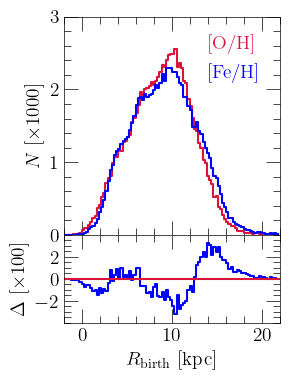

In [5]:
fig = plt.figure(figsize = (3, 4))
ax = fig.add_subplot(111)
res = fig.add_axes([0.1, 0.1, 0.1, 0.1], sharex = ax)
res.set_ylabel(r"$\Delta$ [$\times$100]")
res.set_xlabel(r"$R_\text{birth}$ [kpc]")
ax.set_ylabel(r"$N$ [$\times 1000$]")
ax.set_xlim([-2, 22])
ax.set_ylim([0, 3])
res.set_ylim([-4, 4])
res.set_yticks([-2, 0, 2])
# res.set_yticks([-200, 0, 200, 400])

sub = sample.filter("absz", "<=", 0.5)
kwargs = {
    "bins": 100,
    "range": ax.get_xlim()
}
oh, bins = np.histogram(sub["rbirth_o"], **kwargs)
oh = [_ / 1000 for _ in oh]
feh, bins = np.histogram(sub["rbirth_fe"], **kwargs)
feh = [_ / 1000 for _ in feh]
kwargs = {"where": "post"}
ax.step(bins[:-1], oh, c = named_colors()["crimson"], label = "[O/H]", **kwargs)
ax.step(bins[:-1], feh, c = named_colors()["blue"], label = "[Fe/H]", **kwargs)
delta = [10 * (a - b) for a, b in zip(feh, oh)]
res.step(bins[:-1], delta, c = named_colors()["blue"], **kwargs)
res.axhline(0, c = named_colors()["crimson"])

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])

plt.tight_layout()
plt.subplots_adjust(bottom = 0.4)
res.set_position([
    ax.get_position().x0,
    0.18,
    ax.get_position().x1 - ax.get_position().x0,
    0.22
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/rbirth-distributions.%s" % (ext), **kwargs)
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_48138/357450003.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


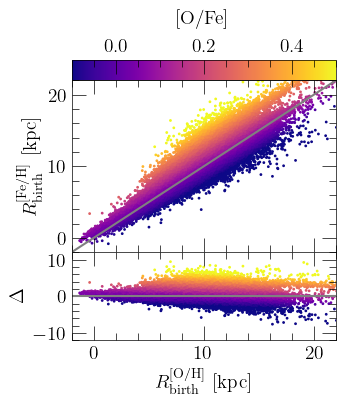

In [25]:
fig = plt.figure(figsize = (3.5, 4))
ax = fig.add_subplot(111)
res = fig.add_axes([0.1, 0.1, 0.1, 0.1], sharex = ax)
# top = fig.add_axes([0.1, 0.2, 0.1, 0.1], sharex = ax)
# right = fig.add_axes([0.1, 0.3, 0.1, 0.1], sharey = ax)
res.set_xlabel(r"$R_\text{birth}^\text{[O/H]}$ [kpc]")
ax.set_ylabel(r"$R_\text{birth}^\text{[Fe/H]}$ [kpc]")
res.set_ylabel(r"$\Delta$")
ax.set_xlim([-2, 22])
ax.set_ylim([-2, 22])
plt.setp(ax.get_xticklabels(), visible = False)
res.set_ylim([-12, 12])

sub = sample.filter("absz", "<=", 0.5)
kwargs = {
    "c": sub["o_fe"],
    "cmap": "plasma",
    "vmin": -0.1,
    "vmax": 0.5,
    "s": 1,
    "rasterized": True
}
ax.scatter(sub["rbirth_o"], sub["rbirth_fe"], **kwargs)
delta = [a - b for a, b in zip(sub["rbirth_fe"], sub["rbirth_o"])]
sc = res.scatter(sub["rbirth_o"], delta, **kwargs)
ax.plot(ax.get_xlim(), ax.get_xlim(), c = named_colors()["grey"], linestyle = "-")
res.set_xlim(ax.get_xlim())
res.axhline(0, c = named_colors()["grey"], linestyle = "-")
cbar_ax = fig.add_axes([0.1, 0.2, 0.1, 0.1])
cbar = plt.colorbar(sc, cax = cbar_ax, orientation = "horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar.set_label(r"[O/Fe]", labelpad = 10)

plt.tight_layout()
plt.subplots_adjust(bottom = 0.38, top = 0.81)
res.set_position([
    ax.get_position().x0,
    0.16,
    ax.get_position().x1 - ax.get_position().x0,
    0.22
])
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/rbirth-oh-vs-feh.%s" % (ext), **kwargs)
plt.show()

1.177450773125659


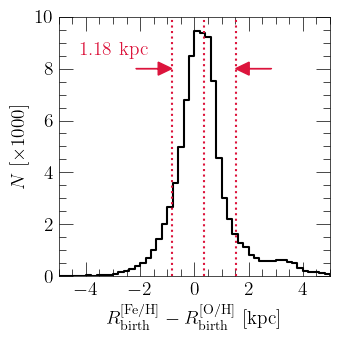

In [28]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{birth}^\text{[Fe/H]} - R_\text{birth}^\text{[O/H]}$ [kpc]")
ax.set_ylabel(r"$N$ [$\times 1000$]")

sub = sample.filter("absz", "<=", 0.5).filter("rbirth_o", ">=", -5) # removes NaNs
delta = [a - b for a, b in zip(sub["rbirth_fe"], sub["rbirth_o"])]
dist, bins = np.histogram(delta, range = [-10, 10], bins = 100)
dist = [_ / 1000 for _ in dist]
ax.step(bins[:-1], dist, where = "post", c = named_colors()["black"])
ax.set_xlim([-5, 5])
ax.set_xticks([-4, -2, 0, 2, 4])
ax.set_ylim([0, 10])

sigma = np.std(delta)
mean = np.mean(delta)
print(sigma)
ax.axvline(mean, c = named_colors()["crimson"], linestyle = ':')
ax.axvline(mean + sigma, c = named_colors()["crimson"], linestyle = ':')
ax.axvline(mean - sigma, c = named_colors()["crimson"], linestyle = ':')
kwargs = {
    "color": named_colors()["crimson"],
    "length_includes_head": True,
    "head_length": 0.5,
    "head_width": 0.5
}
ax.arrow(mean - 2.5, 8, 2.5 - sigma, 0, **kwargs)
ax.arrow(mean + 2.5, 8, sigma - 2.5, 0, **kwargs)
ax.text(-4.2, 8.5, r"$%.2f$ kpc" % (sigma), c = named_colors()["crimson"], fontsize = 14)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/rbirth-diff-dist.%s" % (ext), **kwargs)
plt.show()

In [6]:
def print_info(sub):
    print("================================")
    print("min age: %.2f Gyr" % (min(sub["astronn_age"])))
    print("max age: %.2f Gyr" % (max(sub["astronn_age"])))
    print("mean displacement: %.2f Gyr" % (np.mean(sub["deltar"])))
    print("standard deviation: %.2f Gyr" % (np.std(sub["deltar"])))

def boxcarsmoothdist(sub, xvals):
    dist = []
    for x in xvals:
        subsub = sub.filter(
            "deltar", ">=", x - WINDOW).filter(
            "deltar", "<=", x + WINDOW)
        dist.append(len(subsub["deltar"]))
    norm = sum(dist) * (xvals[1] - xvals[0])
    return [_ / norm for _ in dist]

min age: 0.13 Gyr
max age: 9.00 Gyr
mean displacement: -0.25 Gyr
standard deviation: 3.02 Gyr
min age: 0.13 Gyr
max age: 1.00 Gyr
mean displacement: -0.28 Gyr
standard deviation: 1.87 Gyr
min age: 1.00 Gyr
max age: 2.00 Gyr
mean displacement: -0.18 Gyr
standard deviation: 2.10 Gyr
min age: 2.00 Gyr
max age: 3.00 Gyr
mean displacement: -0.37 Gyr
standard deviation: 2.24 Gyr
min age: 3.00 Gyr
max age: 4.00 Gyr
mean displacement: -0.57 Gyr
standard deviation: 2.54 Gyr
min age: 4.00 Gyr
max age: 5.00 Gyr
mean displacement: -0.38 Gyr
standard deviation: 2.96 Gyr
min age: 5.00 Gyr
max age: 6.00 Gyr
mean displacement: 0.09 Gyr
standard deviation: 3.29 Gyr
min age: 6.00 Gyr
max age: 7.00 Gyr
mean displacement: 0.23 Gyr
standard deviation: 3.43 Gyr
min age: 7.00 Gyr
max age: 8.00 Gyr
mean displacement: 0.05 Gyr
standard deviation: 3.90 Gyr
min age: 8.00 Gyr
max age: 9.00 Gyr
mean displacement: -0.80 Gyr
standard deviation: 4.24 Gyr


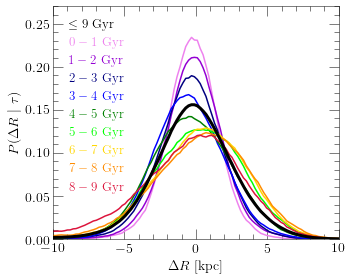

In [7]:
AGE_BINS = list(range(10))
COLORS = ["violet", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson"]
WINDOW = 1

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$\Delta R$ [kpc]")
ax.set_ylabel(r"$P(\Delta R\ |\ \tau)$")
ax.set_xlim([-10, 10])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_ylim([0, 0.27])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])

xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
sub = sample.filter("deltar", ">=", -100) # filter NaNs
# bins = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], NBINS + 1)
# centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
ax.plot(xvals, boxcarsmoothdist(sub, xvals), c = named_colors()["black"],
    label = r"$\leq 9$ Gyr", linewidth = 3, zorder = 100)
print_info(sub)

for i in range(len(AGE_BINS) - 1):
    sub = sample.filter(
        "deltar", ">=", -100).filter(
        "astronn_age", ">=", AGE_BINS[i]).filter(
        "astronn_age", "<=", AGE_BINS[i + 1])
    ax.plot(xvals, boxcarsmoothdist(sub, xvals), c = named_colors()[COLORS[i]],
        label = r"$%d - %d$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1]))
    print_info(sub)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 13
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["black"] + COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/deltar-binned-by-age.%s" % (ext), **kwargs)
plt.show()

0
1
2
3
4
5
6
7
8


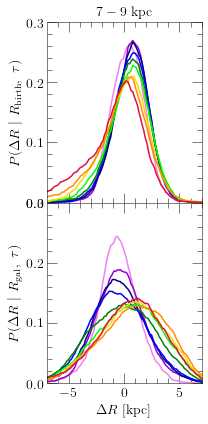

In [11]:
RADIAL_RANGE = [7, 9]
AGE_BINS = list(range(10))
COLORS = ["violet", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson"]
WINDOW = 1

fig = plt.figure(figsize = (3, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
for ax in [ax1, ax2]:
    if i: ax.set_xlabel(r"$\Delta R$ [kpc]")
    ax.set_xlim([-7, 7])
    ax.set_xticks([-5, 0, 5])
    ax.set_ylim([0, 0.3])
    ax.set_yticks([0, 0.1, 0.2, 0.3])
ax1.set_title("$7 - 9$ kpc")
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylabel(r"$P(\Delta R\ |\ R_\text{birth},\ \tau)$")
ax2.set_ylabel(r"$P(\Delta R\ |\ R_\text{gal},\ \tau)$")

xvals = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
sub_birth = sample.filter("rbirth_o", ">=", RADIAL_RANGE[0]).filter("rbirth_o", "<=", RADIAL_RANGE[1])
sub_final = sample.filter("galr", ">=", RADIAL_RANGE[0]).filter("galr", "<=", RADIAL_RANGE[1])
for i in range(len(AGE_BINS) - 1):
    print(i)
    kwargs = {"c": named_colors()[COLORS[i]]}
    sub = sub_birth.filter("astronn_age", ">=", AGE_BINS[i]).filter("astronn_age", "<=", AGE_BINS[i + 1])
    dist = boxcarsmoothdist(sub, xvals)
    ax1.plot(xvals, dist, **kwargs)
    sub = sub_final.filter("astronn_age", ">=", AGE_BINS[i]).filter("astronn_age", "<=", AGE_BINS[i + 1])
    dist = boxcarsmoothdist(sub, xvals)
    ax2.plot(xvals, dist, **kwargs)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/deltar-solar-neighborhood.%s" % (ext), **kwargs)
plt.show()

0
1
2


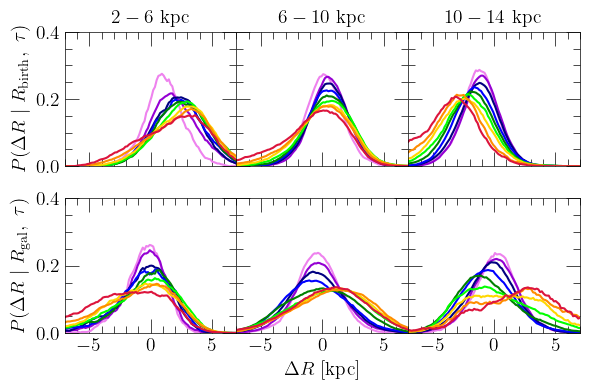

In [18]:
RADIAL_BINS = [2, 6, 10, 14]
AGE_BINS = list(range(10))
COLORS = ["violet", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson"]
WINDOW = 1

fig = plt.figure(figsize = (6, 4))
axes = [[], []]
for i in range(2):
    for j in range(3):
        kwargs = {}
        if j: kwargs["sharey"] = axes[i][0]
        axes[i].append(fig.add_subplot(231 + 3 * i + j, **kwargs))
        if j:
            plt.setp(axes[i][j].get_yticklabels(), visible = False)
        else:
            plt.setp(axes[i][j].get_yticklabels(), fontsize = 14)
        if i:
            plt.setp(axes[i][j].get_xticklabels(), fontsize = 14)
        else:
            plt.setp(axes[i][j].get_xticklabels(), visible = False)
        axes[i][j].set_xlim([-7, 7])
        axes[i][j].set_xticks([-5, 0, 5])
        axes[i][j].set_ylim([0, 0.4])
        axes[i][j].set_yticks([0, 0.2, 0.4])
        if not i: axes[i][j].set_title(r"$%d - %d$ kpc" % (RADIAL_BINS[j], RADIAL_BINS[j + 1]))
axes[1][1].set_xlabel(r"$\Delta R$ [kpc]", fontsize = 14)
axes[0][0].set_ylabel(r"$P(\Delta R\ |\ R_\text{birth},\ \tau)$", fontsize = 14)
axes[1][0].set_ylabel(r"$P(\Delta R\ |\ R_\text{gal},\ \tau)$", fontsize = 14)

for i in range(len(RADIAL_BINS) - 1):
    print(i)
    xvals = np.linspace(axes[0][i].get_xlim()[0], axes[0][i].get_xlim()[1], 100)
    sub = sample.filter(
        "rbirth_o", ">=", RADIAL_BINS[i]).filter(
        "rbirth_o", "<=", RADIAL_BINS[i + 1])
    for j in range(len(AGE_BINS) - 1):
        subsub = sub.filter(
            "astronn_age", ">=", AGE_BINS[j]).filter(
            "astronn_age", "<=", AGE_BINS[j + 1])
        dist = boxcarsmoothdist(subsub, xvals)
        kwargs = {"c": named_colors()[COLORS[j]]}
        axes[0][i].plot(xvals, dist, **kwargs)
    sub = sample.filter(
        "galr", ">=", RADIAL_BINS[i]).filter(
        "galr", "<=", RADIAL_BINS[i + 1])
    for j in range(len(AGE_BINS) - 1):
        subsub = sub.filter(
            "astronn_age", ">=", AGE_BINS[j]).filter(
            "astronn_age", "<=", AGE_BINS[j + 1])
        dist = boxcarsmoothdist(subsub, xvals)
        kwargs = {"c": named_colors()[COLORS[j]]}
        axes[1][i].plot(xvals, dist, **kwargs)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/deltar-binned-by-rbirth-age.%s" % (ext), **kwargs)
plt.show()

How does the uncertainty in the abundance measurement propogate to the inferred birth radius?
--

Since we are operating under the assumption that there is a direct, one-to-one mapping between the two, error propogation is straightforward with the chain rule:

$$
\begin{align}
\sigma_{R_\text{birth}} &= \left|\frac{dR_\text{birth}}{d\text{[O/H]}}\right| \sigma_{\text{[O/H]}}
\\
&= \left|\nabla\text{[O/H]}^{-1}\right| \sigma_{\text{[O/H]}}
\end{align}
$$

Therefore, the uncertainty goes as the quotient of the abundance uncertainty and the slope of the gradient itself.

In [19]:
deltar_err = len(sample["deltar"]) * [0.]
for i in range(len(deltar_err)):
    deltar_err[i] = sample["o_h_err"][i] / 0.062
sample["deltar_err"] = deltar_err
sub = sample.filter("deltar_err", "<=", 100)

# print(0.02 / 0.062)
# print(np.median(sub["o_h_err"]))
# print(np.median(sub["deltar_err"]))

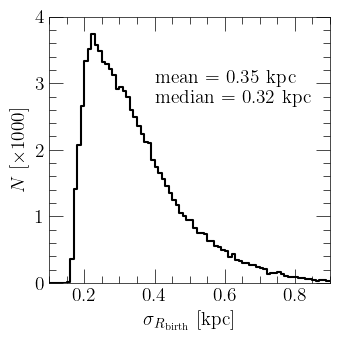

In [21]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$\sigma_{R_\text{birth}}$ [kpc]")
ax.set_ylabel(r"$N$ [$\times 1000$]")
ax.set_xlim([0.1, 0.9])
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_ylim([0, 4])

sub = sample.filter("deltar_err", "<=", 100) # filter out NaNs
dist, bins = np.histogram(sub["deltar_err"], bins = 100, range = [0, 1])
dist = [_ / 1000 for _ in dist]
ax.step(bins[:-1], dist, where = "post", c = named_colors()["black"])
ax.text(0.4, 3, "mean = %.2f kpc" % (np.mean(sub["deltar_err"])), fontsize = 14)
ax.text(0.4, 2.7, "median = %.2f kpc" % (np.median(sub["deltar_err"])), fontsize = 14)

plt.tight_layout()
plt.show()

LinregressResult(slope=0.30090316592843375, intercept=1.5984332698801895, rvalue=0.9938945435726707, pvalue=5.8206272157662874e-08, stderr=0.012625471076864219, intercept_stderr=0.06550255334197119)


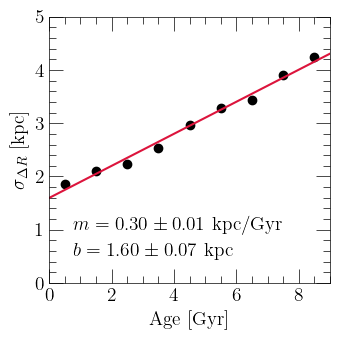

In [7]:
AGE_BINS = list(range(10))

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel(r"$\sigma_{\Delta R}$ [kpc]")
ax.set_xlim([0, 9])
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_ylim([0, 5])

centers = [(a + b) / 2 for a, b in zip(AGE_BINS[:-1], AGE_BINS[1:])]
sigmas = []
for i in range(len(AGE_BINS) - 1):
    sub = sample.filter(
        "astronn_age", ">=", AGE_BINS[i]).filter(
        "astronn_age", "<=", AGE_BINS[i + 1]).filter(
        "deltar", ">=", -100)
    sigmas.append(np.std(sub["deltar"]))
ax.scatter(centers, sigmas, c = named_colors()["black"])

bestfit = linregress(centers, sigmas)
print(bestfit)
bestfit_ = line(bestfit.slope, bestfit.intercept)
ax.plot(ax.get_xlim(), [bestfit_(_) for _ in ax.get_xlim()], c = named_colors()["crimson"])
ax.text(0.75, 1, r"$m = %.2f \pm %.2f$ kpc/Gyr" % (bestfit.slope, bestfit.stderr), fontsize = 14)
ax.text(0.75, 0.5, r"$b = %.2f \pm %.2f$ kpc" % (bestfit.intercept, bestfit.intercept_stderr), fontsize = 14)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./displacements/sigma-vs-age.%s" % (ext), **kwargs)
plt.show()

Can we make sense of stars migrating $\sim$2 kpc in $\sim$500 Myr?
--

[Wenger et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...887..114W/abstract) find non-axisymmetric spatial metallicity variations on the level of ~0.1 dex. With $\nabla\text{[O/H]} = -0.062\ \text{kpc}^{-1}$. If we adopt this value as the width of the [O/H] distribution at fixed radius, then the minimum error on the birth radius comes out from the equation above as $1.61$ kpc, which is consistent with the y-intercept above. Therefore, we can attribute the non-zero y-intercept in this plane *entirely* to the intrinsic metallicity dispersion in the ISM.

Nonetheless, it is possible that there is some short timescale mechanisms that displace stars from their birth radius ([Fujimoto, Inutsuka & Baba 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.3049F/abstract)). The implied radial velocity that the stars would be imparted with is marginal (see below).

The above figure seems to indicate that stars are migrating several kpc *very* quickly. What is the mean radial velocity if a star migrates this distance?

$$
\begin{align}
\langle v_\text{r}\rangle &= \left(\frac{2\ \text{kpc}}{500\ \text{Myr}}\right)
\left(\frac{1\ \text{km/s}}{1\ \text{pc/Myr}}\right)
\left(\frac{1000\ \text{pc}}{1\ \text{kpc}}\right)
\\
&= 4\ \text{km/s},
\end{align}
$$

which is a perfectly reasonable radial velocity. It's peculiar, but perhaps also physically interesting, that the inferred width of the displacement distribution for $0 - 1$ Gyr old stars strongly suggests a non-zero y-intercept. This result indicates a scenario where some process mixes stars radially on kpc scales over a single dynamical time. One hypothesis is that cluster dissociation imparts stars with some *kick velocities*, which would drive an initial burst of radial motion that would dissipate as the stars phase mix into the surrounding velocity field. Radial mixing via churning and blurring would drive further orbital evolution on similar spatial scales but over several Gyr.

Most notably, this result is in tension with Frankel et al.'s (2018) parameterization of $\sigma_{\Delta R}$ as a function of star cluster age, though their functional form enforced a y-intercept of zero. If accurate, this type of mechanism should greatly enhance the variability in enrichment rates for sources where "restitution delays" are expected, such as SN Ia and AGB star enrichment.

In [20]:
np.sqrt(1.18**2 + 0.35**2)

1.2308127396155761

In [22]:
1.62 - 1.18 - 0.35

0.09000000000000019